# <font color='Green'>**To obtian the simulation outputs all the cells below need to be evaluated for initialisation up to and including the main simulation cell**.</font>

## Libraries and functions

In [15]:
import numpy as np
from numpy import inf
from numpy import nan

import math
from scipy.optimize import differential_evolution
from scipy.stats import entropy

import time

import multiprocessing as mp
from pylab import rcParams

import warnings
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')
%matplotlib inline 


 


#parameters


b2 = -6 # quadratic benefit coefficient for task X
beta =3 # slope of benefit for task Y (eg. brood care)
alpha = 1.5 # selection intensity in social learning
popSize = 500 # population size
n =5 # group size for individual interactions
mu = 0.1 # mutation rate
sigma=0.005 #mutation size
#initial traits
x=0.5 
y=0.5



# Total Benefit Accrue to Individuals Inside a Game
def benefit(G,b1,w):
    
    G=np.array(G)
    X = G[:,0]
    Y = G[:,1]
    total_engagement_in_task_X = np.sum(X)
    total_engagement_in_task_Y = np.sum(Y)
    
    B_X = (b2*(total_engagement_in_task_X**2) + (b1*total_engagement_in_task_X))
    B_Y = (1)/(1+ ((1-w*total_engagement_in_task_Y)/(w*total_engagement_in_task_Y))**beta)
    B_total = (1/n)*(B_X)* B_Y
    return(B_total)


# Cost of Task X
def cost_X(player,b1,w):

     return(-1*(player[0]**2) + 2*(player[0]))



# Cost of Task Y
def cost_Y(player,b1,w):
    
	return(-1*(player[1]**2) + 2*(player[1]))


# Total Cost For an Individual
def cost(player,b1,w):
    return (cost_X(player,b1,w) + cost_Y(player,b1,w))


# Payoff Array of the Individuals Inside a Game
def payoffGame(G,b1,w):

    B = np.array(benefit(G,b1,w))
    C = np.array(list(map(cost,G,[b1]*len(G),[w]*len(G))))
    return (B-C)



# Mutations
def mutate_xy(player):

    
    a = np.random.uniform(0,1) 
    b = np.random.uniform(0,1) 
    if a < mu and b < mu:
        return(both_traits_mutation(player[0],player[1]))
    elif a < mu and b > mu:
        return(only_trait1_mutation(player[0],player[1]))
    elif a > mu and b < mu:
        return(only_trait2_mutation(player[0],player[1]))
    else:
        return(player[0],player[1])

def only_trait1_mutation(trait1,trait2):
    flag =0
    while flag==0:
        temp = np.clip(np.random.normal(trait1,sigma),0,1)
        if temp + trait2 <= 1:
            flag = 1
            return(temp,trait2)
        else:
            continue

def only_trait2_mutation(trait1,trait2):
    flag =0
    while flag==0:
        temp = np.clip(np.random.normal(trait2,sigma),0,1)
        if temp + trait1 <= 1:
            flag = 1
            return(trait1,temp)
        else:
            continue
def both_traits_mutation(trait1,trait2):
    flag =0
    while flag==0:
        temp1 = np.clip(np.random.normal(trait1,sigma),0,1)
        temp2 = np.clip(np.random.normal(trait2,sigma),0,1)
        if temp1 + temp2 <= 1:
            flag = 1
            return(temp1,temp2)
        else:
            continue


# One Round Gameplay in Population
def oneRound(b1,w,alpha):
    global population
    global X
    global Y
    global average_allPayoffs
        
    
    np.random.shuffle(population)
    allGames = np.split(population,popSize/n)
    allPayoff = np.array(list(map(payoffGame, allGames,[b1]*len(allGames),[w]*len(allGames))))
    allPayoffs = allPayoff.flatten()
    average_allPayoffs = sum(allPayoffs)/popSize
    allPayoffs = np.exp(np.multiply(allPayoffs,alpha))
    indexes = np.random.choice(np.arange(0,popSize),popSize,replace=True,p=allPayoffs/np.sum(allPayoffs))
    
    parents = np.array([population[i] for i in indexes])
    a=np.where((abs(population[:,0]-parents[:,0])< 0.2) & (abs(population[:,1]-parents[:,1])< 0.2))
    a=np.ndarray.tolist(a[0])
    population=np.ndarray.tolist(population)
    parents=np.ndarray.tolist(parents)
    for i in a:
        population[i][0]=np.copy(parents[i][0])
        population[i][1]=np.copy(parents[i][1])
    population=np.array(population)
    parents=np.array(parents)

    popTemp = np.array(list(map(mutate_xy,population)))
    X = popTemp[:,0]
    Y = popTemp[:,1]
    population[:,0]= X
    population[:,1]= Y   



# Iterative Game Playing
def play(startTrait, tEnd, plotInterval,b1,w,alpha):
    global popSize
    global population
    global X
    global Y
    global average_allPayoffs
    global all_x_traits
    global all_y_traits
    global all_z_traits
    global all_ids
    all_x_traits=[]
    all_y_traits=[]
    all_z_traits=[]
    all_ids=[]
    init_population = []
    for i in range(popSize):
        init_population=init_population+[[0.5,0.5,i]]
    population = np.array(init_population) 
    
    for t in range(1,tEnd+1):
        if (t%plotInterval == 0):
            all_x_traits.append(X)
            all_y_traits.append(Y)
            all_z_traits.append(1-np.array(X)-np.array(Y))
            all_ids.append(population[:,2])
                
        oneRound(b1,w,alpha)    


def getZeroStreaks(L,minSize=2):
    '''
    The function receives a 1-D binary array and finds all [start,end] indice pairs for all consecutive 'zero' sequences with
    length more than "minSize"
    params:
    L: 1-D binary numpy array
    minSize: minimum length of the 'zero sequence'to detect
    '''
    breaks = [i for i,(a,b) in enumerate(zip(L,L[1:]),1) if a!=b]
    return [[s,e-1] for s,e in zip([0]+breaks,breaks+[len(L)])
                        if e-s>=minSize and not L[s]]


# Run function
def run(startTrait, tEnd, plotInterval,b1,w,alpha):
    start = time.time() # should use process_time but only available in Python 3.3 and up 
    play(startTrait, tEnd, plotInterval,b1,w,alpha)
    end = time.time() 
    print("simulation run time in seconds =",end - start)
    plotEvolutions(tEnd, plotInterval,b1,w,alpha)
    return

### Parameters

In [16]:
popSize = 500 # population size
n =5 # group size for individual interactions

mu = 0.1 # mutation rate
sigma=0.005 #mutation size



In [17]:
b2 = -6 # quadratic benefit coefficient for task X
beta =3 # slope of benefit for task Y (eg. brood care)
alpha = 1.5 # selection intensity in social learning

In [18]:
#initial traits
x=0.5 
y=0.5

## Traits Dynamic Plotting

In [19]:
def plotEvolutions(tEnd, plotInterval,b1,w,alpha):

    global x_binned_all
    global y_binned_all
    global z_binned_all
    global popSize
    global all_x_traits
    global all_y_traits
    global all_z_traits
    global cumulative_color_ids

    global x_id1
    global x_id2
    global branch_t_x

    global y_id1
    global y_id2
    global branch_t_y

    global z_id1
    global z_id2
    global branch_t_z
 

    ## Binarize all  trait value vectors (x,y,z) at each time step of the simulation using the defined bin_size
    bin_size = 0.06
    bins = np.arange(0,1+bin_size,bin_size)
    ceiling = len(bins) -2
    x_binned_all = []
    y_binned_all = []
    z_binned_all = []
    
    for steps in range(tEnd//plotInterval):
        x_binned = []
        y_binned = []
        z_binned = []
        for interval in range(len(bins)-1):
            if (np.logical_and(all_x_traits[steps] > bins[interval], all_x_traits[steps] <= bins[interval+1]).any()):
                x_binned.append(1)
            else:
                x_binned.append(0)
                
            if (np.logical_and(all_y_traits[steps] > bins[interval], all_y_traits[steps] <= bins[interval+1]).any()):
                y_binned.append(1)
            else:
                y_binned.append(0)
            
            if (np.logical_and(all_z_traits[steps] > bins[interval], all_z_traits[steps] <= bins[interval+1]).any()):
                z_binned.append(1)
            else:
                z_binned.append(0)
        
        x_binned_all.append(x_binned) 
        y_binned_all.append(y_binned)    
        z_binned_all.append(z_binned)  
        
    
    ## Identify all 'zero' sequences with length more or equal to minSize = 2 using the getZeroStreaks function.
    # These will be gaps larger than minSize * bin_size (2 *0.06) in the vector of each trait value at each time step
    # Disregard sequences which start/end with the floor or ceiling bin indices 
    # (the gaps between the trait values and 0 or trait values and 1 are not indicative of the branching phenomenon)
    # x/y/z_id1: The index where branching starts, x/y/z_id2: The index where branching ends
    # branch_t_x/branch_t_y/branch_t_z: The time point when the branching in x/y/z first occurs. 
    
    x_id1 = []
    x_id2 =[]
    branch_t_x = []
    flag =0

    for steps in range(tEnd//plotInterval):
        if len(getZeroStreaks(x_binned_all[steps]))>0:
            x1_temp = 0
            x2_temp = 0
            branch_temp = 0
            for [i,j] in (getZeroStreaks(x_binned_all[steps])):
                if (i!=0) and (j!=ceiling):
                    x1_temp = i
                    x2_temp = j
                    branch_temp = steps*plotInterval
                    break
                else:
                    pass
            x_id1.append(x1_temp)
            x_id2.append(x2_temp)
            branch_t_x.append(branch_temp)
        else:
            x_id1.append(0)
            x_id2.append(0)
            branch_t_x.append(0)                    


    y_id1 = []
    y_id2 =[]
    branch_t_y = []
    flag =0

    for steps in range(tEnd//plotInterval):
      if len(getZeroStreaks(y_binned_all[steps]))>0:
          y1_temp = 0
          y2_temp = 0
          branch_temp = 0
          for [i,j] in (getZeroStreaks(y_binned_all[steps])):
              if (i!=0) and (j!=ceiling):
                  y1_temp = i
                  y2_temp = j
                  branch_temp = steps*plotInterval
                  break
              else:
                  pass
          y_id1.append(y1_temp)
          y_id2.append(y2_temp)
          branch_t_y.append(branch_temp)
      else:
          y_id1.append(0)
          y_id2.append(0)
          branch_t_y.append(0) 

    z_id1 = []
    z_id2 =[]
    branch_t_z =[]
    flag =0


    for steps in range(tEnd//plotInterval):
      if len(getZeroStreaks(z_binned_all[steps]))>0:
          z1_temp = 0
          z2_temp = 0
          branch_temp = 0
          for [i,j] in (getZeroStreaks(z_binned_all[steps])):
              if (i!=0) and (j!=ceiling):
                  z1_temp = i
                  z2_temp = j
                  branch_temp = steps*plotInterval
                  break
              else:
                  pass
          z_id1.append(z1_temp)
          z_id2.append(z2_temp)
          branch_t_z.append(branch_temp)
      else:
          z_id1.append(0)
          z_id2.append(0)
          branch_t_z.append(0) 

    ## Map the identified indices for the start of each gap (zero sequence longer than 2), to the value of 
    # the corresponding trait. This value would be used as a threhold to differentiate colors of branches above 
    # or below the threshold
        
    
    color_x_start1 = []
    color_y_start1 = []
    color_z_start1 = []
    for steps in range(tEnd//plotInterval):
        if ( (x_id1[steps] and  y_id1[steps])  or (y_id1[steps] and z_id1[steps])):
            color_x_start1.append((x_id1[steps]+x_id2[steps])*0.5 *bin_size)
            color_y_start1.append((y_id1[steps]+y_id2[steps])*0.5 *bin_size)
            color_z_start1.append((z_id1[steps]+z_id2[steps])*0.5 *bin_size)
        else:
            color_x_start1.append(0)
            color_y_start1.append(0)
            color_z_start1.append(0)

      

    cumulative_color_ids = []        
    for steps in range(tEnd//plotInterval):
        color_ids = np.array([0]*popSize)
        if ((branch_t_x[steps] and branch_t_y[steps])  or (branch_t_y[steps] and branch_t_z[steps] ) ):
            color_ids[np.array(all_y_traits[steps])>color_y_start1[steps]]=1
            color_ids[np.array(all_y_traits[steps])<color_y_start1[steps]]=-1

        cumulative_color_ids.append(color_ids)

    ## Define 't' and 'trait' vectors for the plot
    t = np.array([ np.full(popSize,i*plotInterval) for i in range(1,1+tEnd//plotInterval) ]).flatten()
    x = np.array(all_x_traits).flatten()
    y=np.array(all_y_traits).flatten()
    # ids= np.array(all_ids).flatten()
    ids= np.array(cumulative_color_ids).flatten()


   

    
    plt.rcParams["font.family"] = "sans-serif"
    font = FontProperties()
    
        
  ##############################################################################################################    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4))
    ax1.plot(t[ids==0],x[ids==0], '.',color='mediumvioletred', markersize=0.1, alpha = 1, label = 'x')    
    ax1.plot(t[ids==1],x[ids==1], '.',color='#104E8B', markersize=0.1, alpha = 1)   
    ax1.plot(t[ids==-1],x[ids==-1], '.',color='#FFD700', markersize=0.1, alpha = 1)   
        
        
    ax1.set_xlabel('time', fontsize=16,fontweight="bold")
    ax1.set_ylabel('x', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties)
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax1.margins(0)

    legend = ax1.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax1.set_xlabel('time', fontsize=16,fontweight="bold")
    ax1.set_ylabel('x', fontsize=16,fontweight="bold")
    ax1.get_legend().remove()
    ax1.set_ylim([0, 1])

    
    plt.ylim((0,1))
    plt.grid(False)  
    
    
    ############ No colouring#############
    
    ax2.plot(t, x, '.', color='mediumvioletred', markersize=0.05,label='x')
    legend = ax2.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax2.set_xlabel('time', fontsize=16,fontweight="bold")
    ax2.set_ylabel('x', fontsize=16,fontweight="bold")
    ax2.set_title('Without coloring branches')
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax2.set_xticklabels(ax2.get_xticks(), fontproperties)
    ax2.set_yticklabels(ax2.get_yticks(), fontproperties)
    ax2.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax2.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax2.margins(0)

    plt.ylim((0,1))
    plt.grid(False)
    plt.show()
    
    
    
  ##############################################################################################################    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4))
    
    ax1.plot(t[ids==0],y[ids==0], '.',color='seagreen', markersize=0.1, alpha = 1, label = 'y')    
    ax1.plot(t[ids==1],y[ids==1], '.',color='#104E8B', markersize=0.1, alpha = 1)   
    ax1.plot(t[ids==-1],y[ids==-1], '.',color='#FFD700', markersize=0.1, alpha = 1) 

    ax1.set_xlabel('time', fontsize=16,fontweight="bold")
    ax1.set_ylabel('y', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties)
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax1.margins(0)

      
    legend = ax1.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax1.set_xlabel('time', fontsize=16,fontweight="bold")
    ax1.set_ylabel('y', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties)
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax1.margins(0)
    ax1.set_ylim([0, 1])
    ax1.get_legend().remove()

    plt.ylim((0,1))
    plt.grid(False)    
    
    
    ############ No colouring#############
    ax2.plot(t, y, '.',color='seagreen', markersize=0.05,label='y')
    
    legend = ax2.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax2.set_xlabel('time', fontsize=16,fontweight="bold")
    ax2.set_ylabel('y', fontsize=16,fontweight="bold")
    ax2.set_title('Without coloring branches')
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax2.set_xticklabels(ax2.get_xticks(), fontproperties)
    ax2.set_yticklabels(ax2.get_yticks(), fontproperties)
    ax2.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax2.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax2.margins(0)

    plt.ylim((0,1))
    plt.grid(False)    
    plt.show()


    
 ##############################################################################################################    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,4))
   
    ax1.plot(t[ids==0],1-x[ids==0]-y[ids==0], '.',color='midnightblue', markersize=0.1, alpha = 1, label = 'z')    
    ax1.plot(t[ids==1],1-x[ids==1]-y[ids==1], '.',color='#104E8B', markersize=0.1, alpha = 1)   
    ax1.plot(t[ids==-1],1-x[ids==-1]-y[ids==-1], '.',color='#FFD700', markersize=0.1, alpha = 1) 

    ax1.set_xlabel('time', fontsize=16,fontweight="bold")
    ax1.set_ylabel('z', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties)
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax1.margins(0)

    legend = ax1.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax1.set_xlabel('time', fontsize=16,fontweight="bold")
    ax1.set_ylabel('z', fontsize=16,fontweight="bold")
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties)
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax1.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax1.margins(0)
    ax1.set_ylim([0, 1])
    ax1.get_legend().remove()

    plt.ylim((0,1))
    plt.grid(False) 

    
    
    
    ############ No colouring#############
    
    ax2.plot(t, 1-x-y, '.',color='midnightblue',markersize=0.05, label='z')
    legend = ax2.legend(bbox_to_anchor=(0.3, 0.94, 1., .102),markerscale=240, shadow=True,prop={'size':14,'weight':'bold'})
    ax2.set_xlabel('time', fontsize=16,fontweight="bold")
    ax2.set_ylabel('z', fontsize=16,fontweight="bold")
    ax2.set_title('Without coloring branches')
    
    fontproperties = {'weight' : 'bold', 'size' : 12}
    ax2.set_xticklabels(ax2.get_xticks(), fontproperties)
    ax2.set_yticklabels(ax2.get_yticks(), fontproperties)
    ax2.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax2.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax2.margins(0)

    plt.ylim((0,1))
    plt.grid(False) 
    plt.show()


## <font color='Red'>**The main cell for running the simmulation**.</font>
### <font color='Purple'>All above cells need to be run to initialize the necessary functions and dependencies.</font>








###Random sampling inside an area of branching region

The simulation randomly selected b = 22.342429904996433  and w = 0.26577192736238775 in the branchign region
Depending on colab's load you can expect to wait up to 7 minutes for the simulation to finish.
simulation run time in seconds = 362.13287019729614


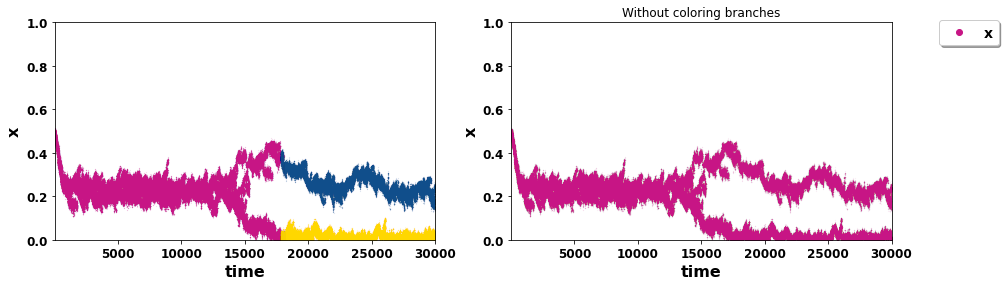

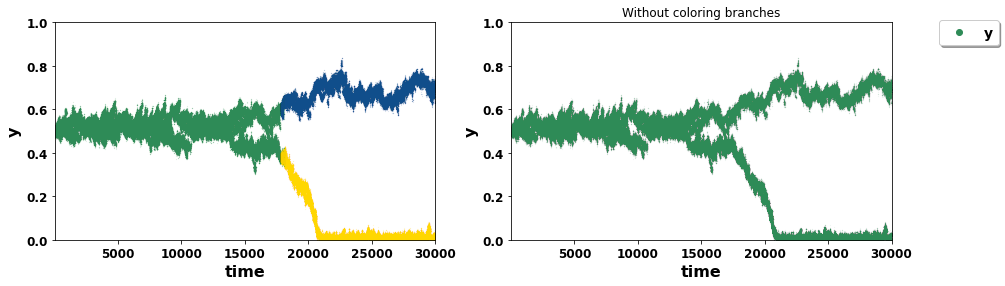

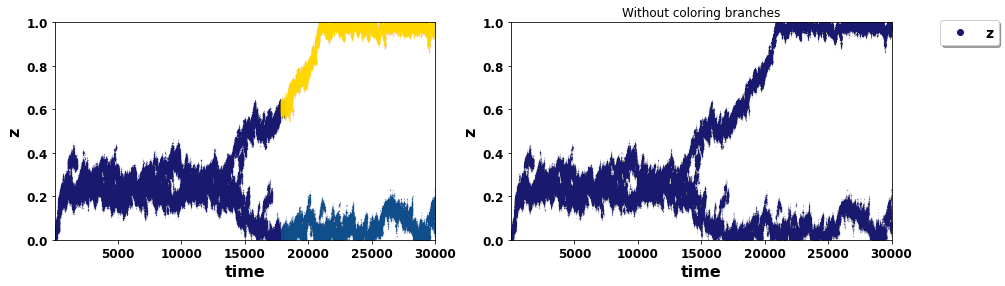

In [26]:
b = np.random.uniform(21.5, 22.9)
w = np.random.uniform(0.25, 0.3)

print("The simulation randomly selected b =",b," and w =",w,"in the branchign region")
print("Depending on colab's load you can expect to wait up to 7 minutes for the simulation to finish.")
run([x,y],30000,10,b,w,1.5)

The simulation randomly selected b = 22.090213557376075  and w = 0.2878949229785552 in the branchign region
Depending on colab's load you can expect to wait up to 8 minutes for the simulation to finish.
simulation run time in seconds = 356.46766543388367


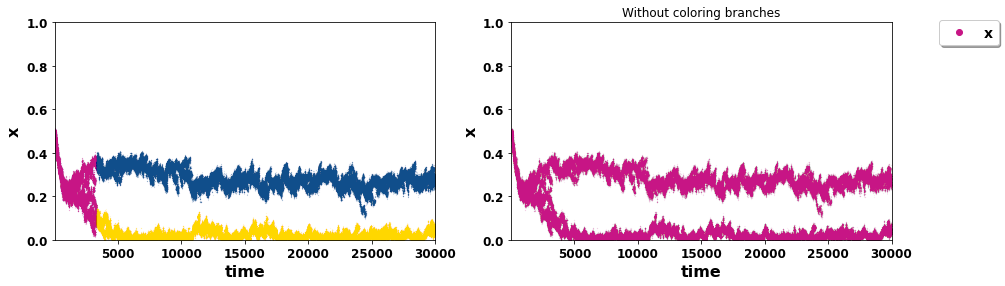

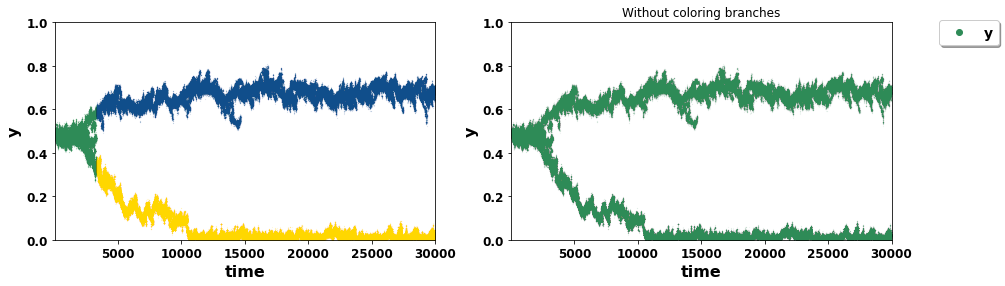

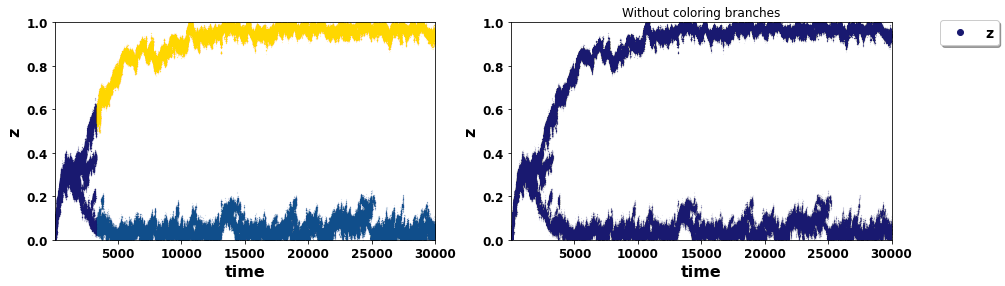

In [20]:
b = np.random.uniform(21.5, 22.9)
w = np.random.uniform(0.25, 0.3)

print("The simulation randomly selected b =",b," and w =",w,"in the branchign region")
print("Depending on colab's load you can expect to wait up to 7 minutes for the simulation to finish.")
run([x,y],30000,10,b,w,1.5)

## Sample run in the branching region for longer T

/Users/mkha0093/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


871.8652029037476


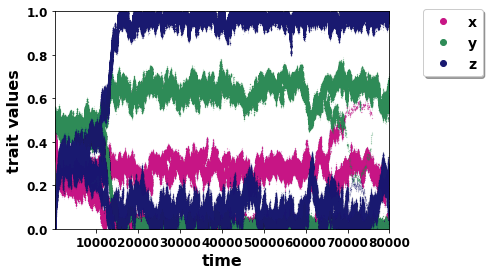

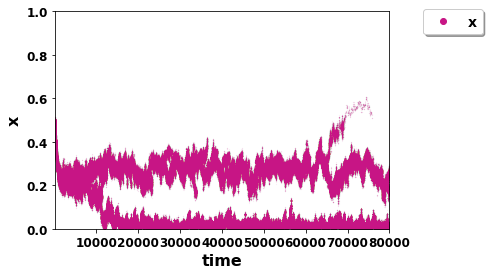

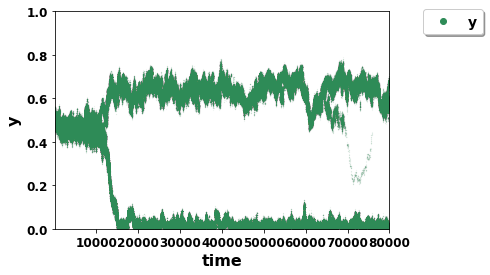

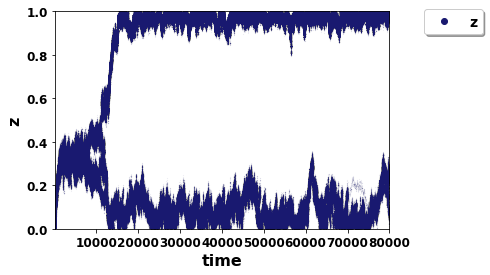

34.46615357404987

In [ ]:
run([[x,y]],80000,10,22,0.3,1.5)